# 1. Setup

In [1]:
from mobilkit.umni import *

In [2]:
import yaml

# 2. Prepare data


## 2.1. Download from Google

The [old disastrous] code for downloading distances & travel times for Indiana 2010 zones using the **Google Distance Matrix (GDM)** API is written in `./gdm.py`.

## 2.2. Download with OSRM
The travel time requests from the local server is in `osrm_server.sh`.

### 2.2.1. Prepare MSA lists

In [3]:
with open('../data/osm/msa2usregion.yml', 'r') as f:
    msa2rgn = yaml.safe_load(f)
    
msa2rgn = Seq(msa2rgn, name='region').rename_axis('cbsa').reset_index().disp(2)

50 rows x 2 cols; Memory: 0.0 MiB


,cbsa,region
,<object>,<object>
0,"Atlanta-Sandy Springs-Roswell, GA",south
1,"Austin-Round Rock-San Marcos, TX",south


In [4]:
def get_msa_poly_coords(year=2020, msa2rgn=msa2rgn):
    df = gpd.read_parquet(f'../data/zones/msa_{year}.parquet')
    df = df[df['scale'] == 'COUNTY']
    df = df[['cbsa_id', 'cbsa', 'geometry']]
    df = df.dissolve('cbsa_id').reset_index()
    df = df.merge(msa2rgn, on='cbsa', how='left').set_index('cbsa_id')
    df = df.explode(subset='geometry', index_parts=True)
    df = df.rename_axis(('cbsa_id', 'part')).reset_index()
    df['area'] = df.to_crs(CRS_M).area
    df = df.sort_values('area').groupby('cbsa_id').last()
    df = df[['cbsa', 'region', 'geometry']].reset_index()
    df['bbox'] = df.bounds.astype(str).apply(','.join, axis=1)
    df = df.set_crs(CRS_DEG).set_index('cbsa_id')
    return df

msas = get_msa_poly_coords().disp()

50 rows x 4 cols; Memory: 0.0 MiB; CRS: EPSG:4326


,cbsa,region,geometry,bbox
cbsa_id,<object>,<object>,<geometry>,<object>
12060,"Atlanta-Sandy Springs-Roswell, GA",south,"POLYGON ((-84.863254 33.107112, -84.863253 33....","-85.38658099999999,32.84464,-83.269196,34.740859"


### 2.2.2. Save JSON file for each city

In [6]:
# # t=0:04
# for cbsa_id, r in tqdm(msas.iterrows(), total=len(msas)):
#     outpath = Path(f'../data/osm/msa_json/{r.region}/{cbsa_id}.geojson')
#     df = Gdf(r.to_frame().T, crs=CRS_DEG)
#     df.to_file(U.mkfile(outpath), driver='GeoJSON')

### 2.2.3. Extract city OSM using polygon file

In [6]:
%%bash
function doregion { # doregion [region]
    # cd ../data/osm
    mkdir -p msa_pbf
    # declare the large US regional OSM file
    rgnosm=rgn_osm/$1.osm
    # for each MSA in the JSON file directory
    for fjson in msa_json/$1/*; do
        # get the CBSA ID from the JSON file
        fname=$(basename $fjson)
        cbsa=${fname%.*}
        # define the temporary OSM and output PBF files
        fosm=msa_osm/$cbsa.osm
        fbpf=msa_pbf/$cbsa.pbf
        # proceed only if the outfile does not exist
        if ! [ -f $fpbf ]; then
            echo "Processing $1 $cbsa"
            # extract the MSA file from the regional file using polygon
            osmium extract -p $fjson $rgnosm -o $fosm
            # compress the extracted MSA database file
            osmium cat $fosm -o msa_pbf/$cbsa.pbf
            # remove the large MSA extract
            rm $fosm
        else
            echo "Skipping $1 $cbsa"
        fi
    done
}
# time for rgn in midwest northeast south west; do doregion $rgn; done # t > 10 hours

# 3. Visualize

## 3.1. OSRM travel times

In [30]:
df = pd.read_parquet('../data/osrm/indiana/indiana_bg_drive_2010.parquet')
df['duration'] /= 60 # seconds to minutes
df = df[df.duration <= 360].disp()

22,704,277 rows x 3 cols; Memory: 347.3 MiB


,src_geoid,trg_geoid,duration
,<category>,<category>,<float32>
0,180010301002,180010301001,20.526667


In [23]:
df2 = df.merge(odpIN10[['src_geoid', 'trg_geoid']]).disp(0)

3,449,963 rows x 3 cols; Memory: 467.2 MiB


,src_geoid,trg_geoid,duration
,<object>,<object>,<float32>


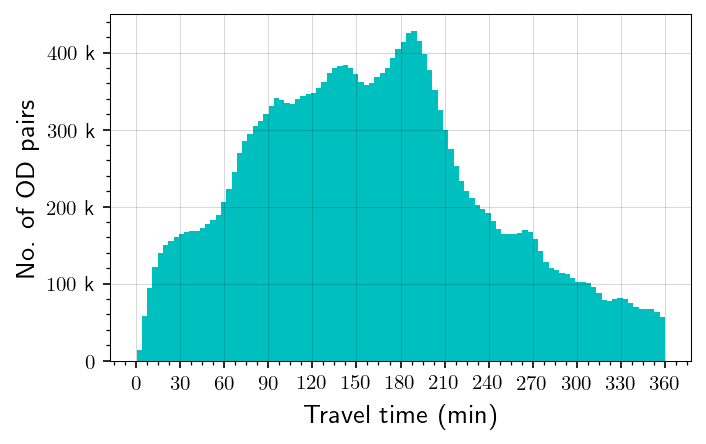

In [31]:
ax = U.plot(size=(5, 3), xlab='Travel time (min)', ylab='No. of OD pairs', yeng=1)
df.duration.hist(ax=ax, bins=100, color='c')
plt.xticks(np.arange(0, 361, 30));
# U.plot_func_value_line(ax, 60, 2.2e5, color='k', lw=0.75)
# U.plot_func_value_line(ax, 90, 2.5e4, color='k', lw=0.75);

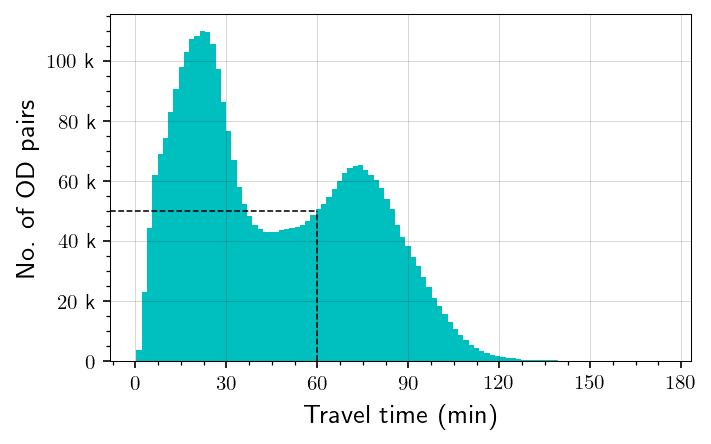

In [27]:
ax = U.plot(size=(5, 3), xlab='Travel time (min)', ylab='No. of OD pairs', yeng=1)
df2.duration.hist(ax=ax, bins=100, color='c')
plt.xticks(np.arange(0, 181, 30))
U.plot_func_value_line(ax, 60, 5e4, color='k', lw=0.75);

## 3.2. GDM deterrence

In [9]:
gdm = (pd.read_parquet('../data/gdm/in_2010.parquet')
       .query('day_type == "weekday"').dropna()
       [['scale', 'mode', 'dist', 'time', 'speed']]).disp()
gdm.dist *= U.M2MI # distance meters to miles
gdm.time /= 60 # time seconds to minutes
gdm.speed *= (U.M2MI * 3600) # m/s to mi/h

7,004,168 rows x 5 cols; Memory: 147.0 MiB


,scale,mode,dist,time,speed
,<category>,<category>,<float32>,<float32>,<float32>
0,tract,transit,4480.0,3268.0,1.370869


### 3.2.1. Travel time and distance

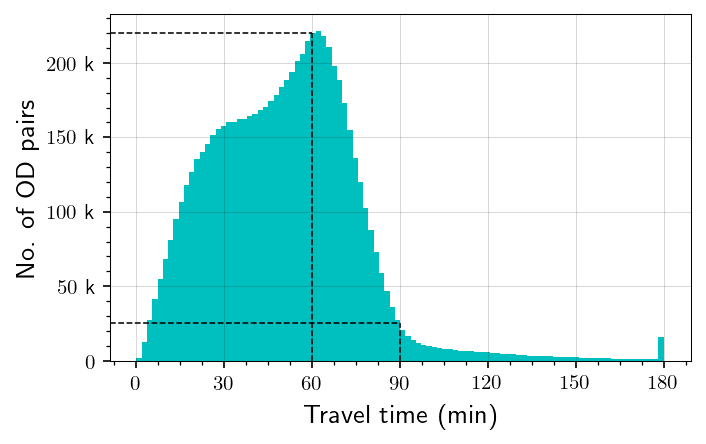

In [29]:
ax = U.plot(size=(5, 3), xlab='Travel time (min)', ylab='No. of OD pairs', yeng=1)
gdm.time.clip(0, 180).hist(ax=ax, bins=100, color='c')
plt.xticks(np.arange(0, 181, 30))
U.plot_func_value_line(ax, 60, 2.2e5, color='k', lw=0.75)
U.plot_func_value_line(ax, 90, 2.5e4, color='k', lw=0.75);

  0%|          | 0/3 [00:00<?, ?it/s]

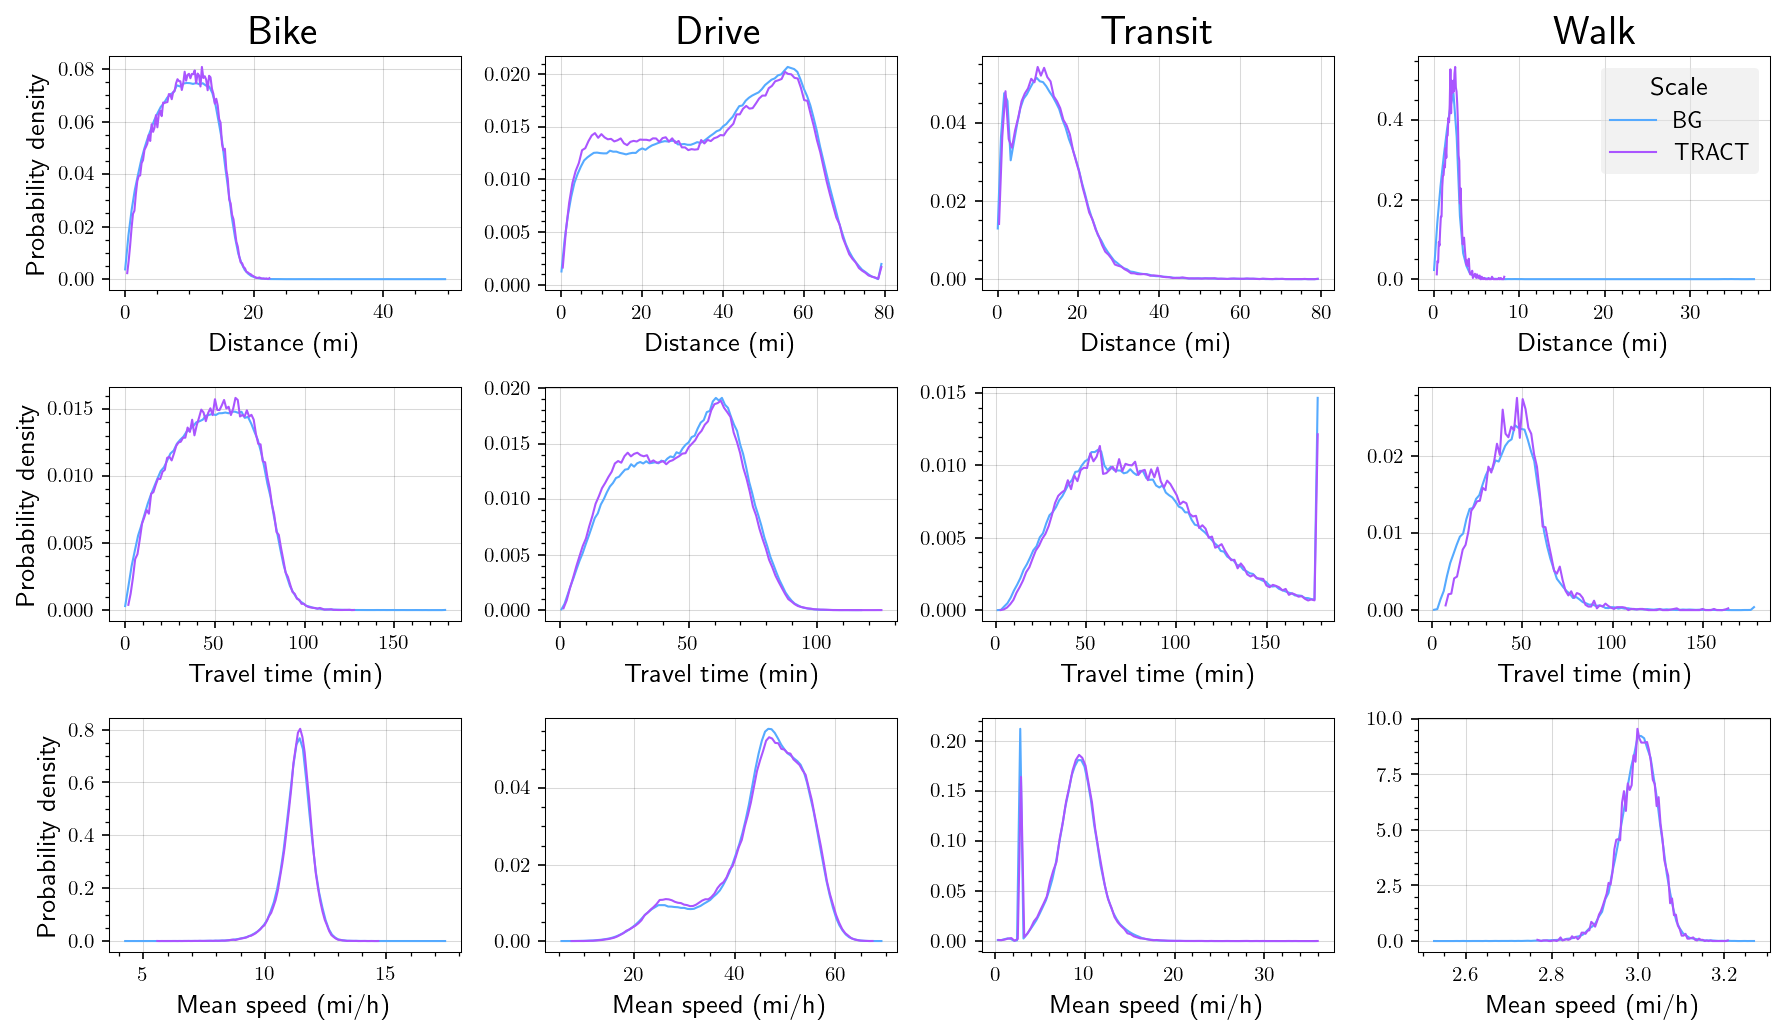

In [11]:
def plot_distrs(tt, scales=('BG', 'TRACT'),
                modes=list(max_speeds.keys()), cols=(
                    ('dist', 'Distance (mi)', 80),
                    ('time', 'Travel time (min)', 180),
                    ('speed', 'Mean speed (mi/h)', 70),
                ), size=(12, 7), dpi=150, cmap='cool'):
    _, axes = plt.subplots(len(cols), len(modes), figsize=size, dpi=dpi)
    for i, (var, xlabel, vmax) in enumerate(tqdm(cols)):
        for j, mode in enumerate(modes):
            ax = U.plot(axes[i, j], xlab=xlabel,
                        ylab='Probability density' if j == 0 else '')
            if i == 0: ax.set_title(mode.title(), fontsize=20)
            for k, scale in enumerate(scales):
                color = sns.color_palette(cmap, len(scales))[k]
                df = tt[tt['scale'] == scale.lower()]
                df = df[df['mode'] == mode.lower()]
                y, x = np.histogram(df[var].clip(0, vmax), bins=100, density=True)
                ax.plot(x[:-1], y, color=color, lw=1, label=scale)
    axes[0, -1].legend(title='Scale', loc='upper right')
    plt.tight_layout()

plot_distrs(gdm) # t=0:08

In [ ]:
def plot_violin(tt, speeds=max_speeds, max_time=3600):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for i, (var, label, vmax, yvals) in enumerate(tqdm([
        ('time', 'Travel time (min)', 180, [15, 30, 45, 60]),
        ('dist', 'Distance (mi)', 80, MODES.max_speed * max_time / 60),
        # ('speed', 'Speed (mi/h)', 60, MODES.max_speed)
    ])):
        ax = U.plot(axes[i], ylim=(0, vmax))
        for y in yvals: ax.axhline(y, lw=.75, ls=':', color='k')
        ax = sns.violinplot(tt, ax=ax, x='mode', y=var, hue='scale',
                            inner='quartile', split=True,
                            palette='cool', linewidth=1)
        for col in ax.collections: col.set_edgecolor('none')
        if var == 'time':
            ax.set_yticks(np.arange(0, 180+1, 30))
            ax.axhline(60, lw=1.5, ls=':', color='r')
        ax.legend(handles=ax.legend_.legend_handles, loc='upper right')
        ax = U.plot(ax, xlab='', ylab=label)
    plt.tight_layout()
    U.plot_panel_labels(x=-0.12, y=1, va='top')

plot_violin(gdm) # t=0:43